In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %config Completer.use_jedi = False
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from matplotlib.widgets import MultiCursor, Cursor
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression
from sidecar import Sidecar

os.chdir("..")
from src import definitions as defs
from src import features, models

In [2]:
wdir = defs.ROOT / "data"

In [3]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))
data.elevation = data.elevation.interpolate(method="time", limit=1, limit_direction="both")
data["elapsed"] = data.index - data.index[0]
data = data[["elapsed", "elevation"]]

In [4]:
data[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]
data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [43]:
dt = pd.Timedelta("30 days")
stds = 3
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_for_roll = data.loc[data.high == True].loc[data.loc[data.high == True].elevation.between(bot, top)].elevation

r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_for_roll = data.loc[data.low == True].loc[data.loc[data.low == True].elevation.between(bot, top)].elevation

In [44]:
highs_excl = data.loc[data.high == True].loc[data.loc[data.high == True].index.difference(other=highs_for_roll.index)]
lows_excl = data.loc[data.low == True].loc[data.loc[data.low == True].index.difference(other=lows_for_roll.index)]

In [49]:
data["high_roll"] = highs_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = lows_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [13]:
data["high_roll"] = data.elevation.loc[data.high == True].rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = data.elevation.loc[data.low == True].rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [51]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)
# high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, is_sorted=True) for endog in endogs)

In [52]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [91]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

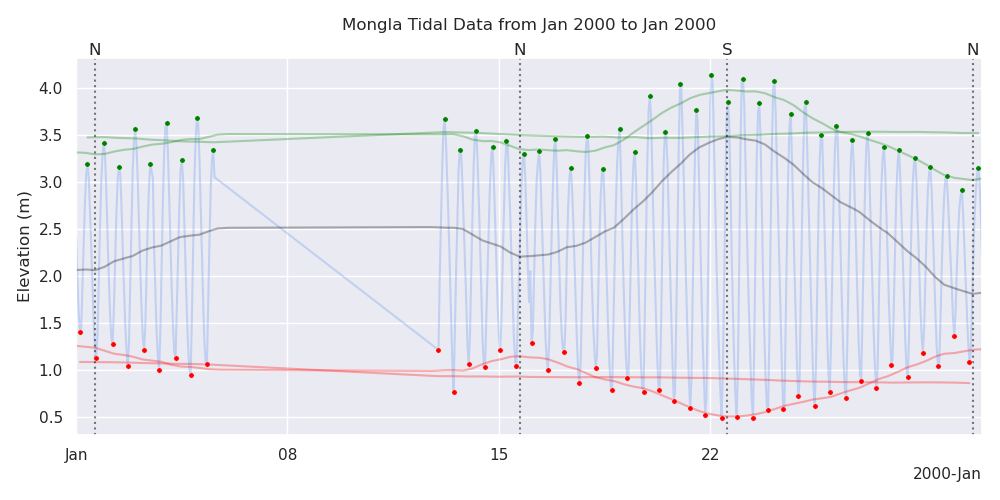

In [110]:
window = window
start = pd.to_datetime("2000-01-01")
end = start + pd.Timedelta("30D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.lineplot(data=r_high.mean().loc[start:end], color="green", alpha=0.3, ax=ax)
sns.lineplot(data=r_low.mean().loc[start:end], color="red", alpha=0.3, ax=ax)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [111]:
subset = data.loc["1998":"2009"].copy()
subset.elapsed = subset.index - subset.index[0]

nodal_amp = 0.045
nodal_freq = 18.61
phase_start = pd.to_datetime("2015-10-01")

subset["nodal"] = nodal_amp * np.sin(2 * np.pi * ((subset.index - phase_start) / (pd.Timedelta("365.25 days") * nodal_freq)) + np.pi / 2)
subset["elev_adj"] = subset.elevation - subset.nodal

In [112]:
def lm_tides(data, ref_date, time_unit="365.25 days"):

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    y_pred = lm.predict(x)

    ts = pd.Series(data=y_pred.flatten(), index=data.index)

    index = ("lm", "coef", "intercept", "TS")
    data = (lm, lm.coef_[0, 0], lm.intercept_[0], ts)

    s = pd.Series(data=data, index=index)

    return(s)

In [122]:
daily = subset.groupby(by=pd.Grouper(freq="D")).agg({"elev_adj": ["max", "min"]})
daily.columns = daily.columns.droplevel()
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})

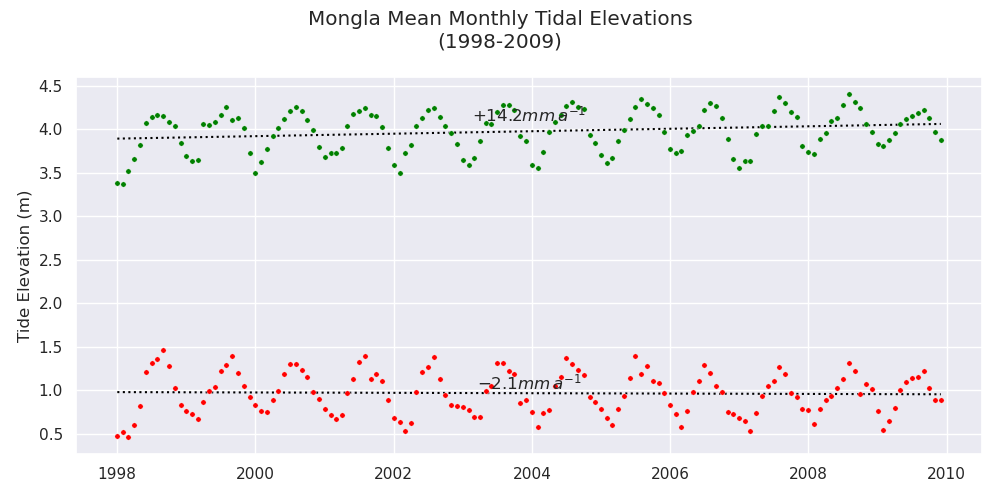

In [131]:
monthly_lm = monthly.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MHW", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MLW", color="red", s=15, ax=ax, zorder=15)

sns.lineplot(data=monthly_lm.MHW.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=monthly_lm.MLW.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=monthly_lm.MHW.TS.index.mean(), y=monthly_lm.MHW.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MHW.coef * 1000), fontsize="medium")
ax.text(x=monthly_lm.MLW.TS.index.mean(), y=monthly_lm.MLW.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MLW.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Tide Elevation (m)")

title = "Mongla Mean Monthly Tidal Elevations\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [132]:
springs = subset.loc[subset.spring == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = subset.loc[subset.neap == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [133]:
spring_lm = springs.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))
neap_lm = neaps.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

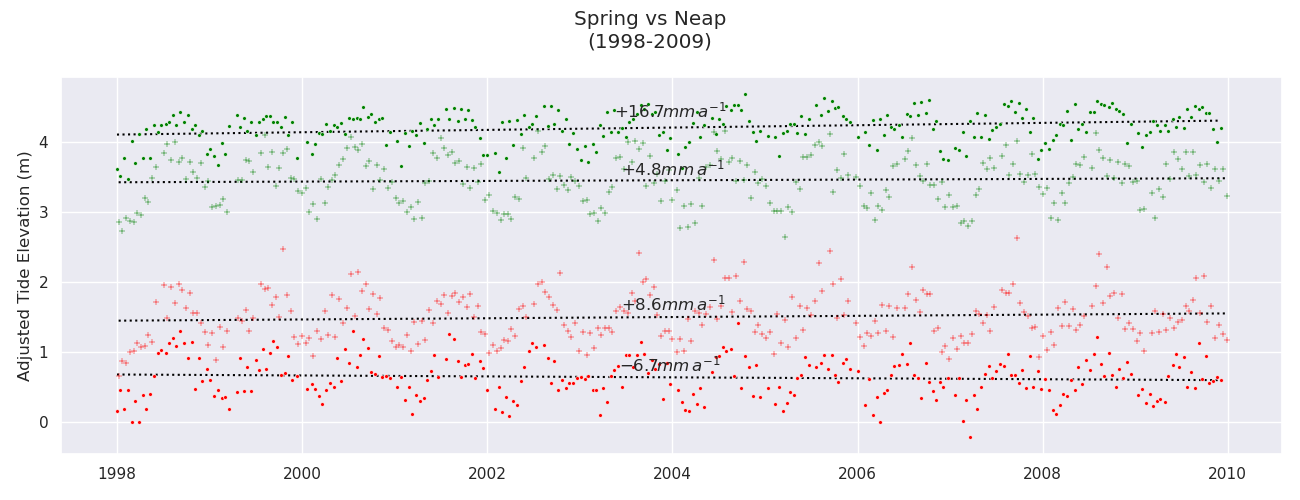

In [134]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=springs.reset_index(), x="datetime", y="high", color="green", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="high", color="green", marker="+", s=20, ax=ax, zorder=15)
sns.scatterplot(data=springs.reset_index(), x="datetime", y="low", color="red", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="low", color="red", marker="+", s=20, ax=ax, zorder=15)

sns.lineplot(data=spring_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=spring_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_lm.high.TS.index.mean(), y=spring_lm.high.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.high.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.high.TS.index.mean(), y=neap_lm.high.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.high.coef * 1000), fontsize="medium")
ax.text(x=spring_lm.low.TS.index.mean(), y=spring_lm.low.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.low.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.low.TS.index.mean(), y=neap_lm.low.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.low.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Adjusted Tide Elevation (m)")

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [153]:
spring_amp

datetime
1998-01-01 07:30:00    3.464999
1998-01-14 10:30:00    3.066666
1998-01-30 16:30:00    3.590003
1998-02-13 18:00:00    3.015003
1998-02-28 18:00:00    4.015002
                         ...   
2009-10-05 00:00:00    3.473336
2009-10-18 10:30:00    3.861670
2009-11-04 15:00:00    3.614994
2009-11-17 10:30:00    3.360012
2009-12-04 15:00:00    3.609993
Length: 280, dtype: float64

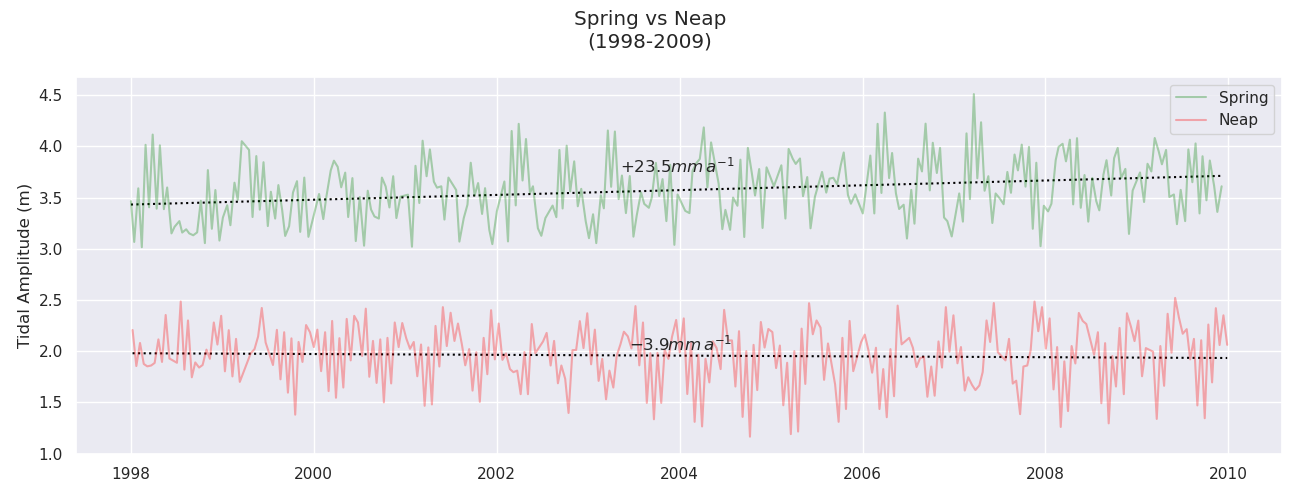

In [154]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

spring_amp = (springs.high - springs.low).dropna()
neap_amp = (neaps.high - neaps.low).dropna()

spring_amp_lm = lm_tides(data=spring_amp, ref_date=subset.index[0], time_unit="365.25 days")
neap_amp_lm = lm_tides(data=neap_amp, ref_date=subset.index[0], time_unit="365.25 days")

sns.lineplot(data=spring_amp, color="green", alpha=0.3, ax=ax, zorder=15, label="Spring")
sns.lineplot(data=neap_amp, color="red", alpha=0.3, ax=ax, zorder=15, label="Neap")

sns.lineplot(data=spring_amp_lm.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_amp_lm.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_amp_lm.TS.index.mean(), y=spring_amp_lm.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_amp_lm.coef * 1000), fontsize="medium")
ax.text(x=neap_amp_lm.TS.index.mean(), y=neap_amp_lm.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_amp_lm.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Tidal Amplitude (m)")

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [161]:
# subset into springs and neaps
springs = subset.loc[(subset.spring == True)][["high_smooth", "low_smooth", "nodal"]].rename(columns={"high_smooth": "HW", "low_smooth": "LW"})
neaps = subset.loc[(subset.neap == True)][["high_smooth", "low_smooth", "nodal"]].rename(columns={"high_smooth": "HW", "low_smooth": "LW"})

# remove nodal tide
springs[["HW_adj", "LW_adj"]] = springs[["HW", "LW"]].subtract(springs.nodal, axis=0)
neaps[["HW_adj", "LW_adj"]] = neaps[["HW", "LW"]].subtract(neaps.nodal, axis=0)

# Apply lm function to data
spring_lm = springs.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))
neap_lm = neaps.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

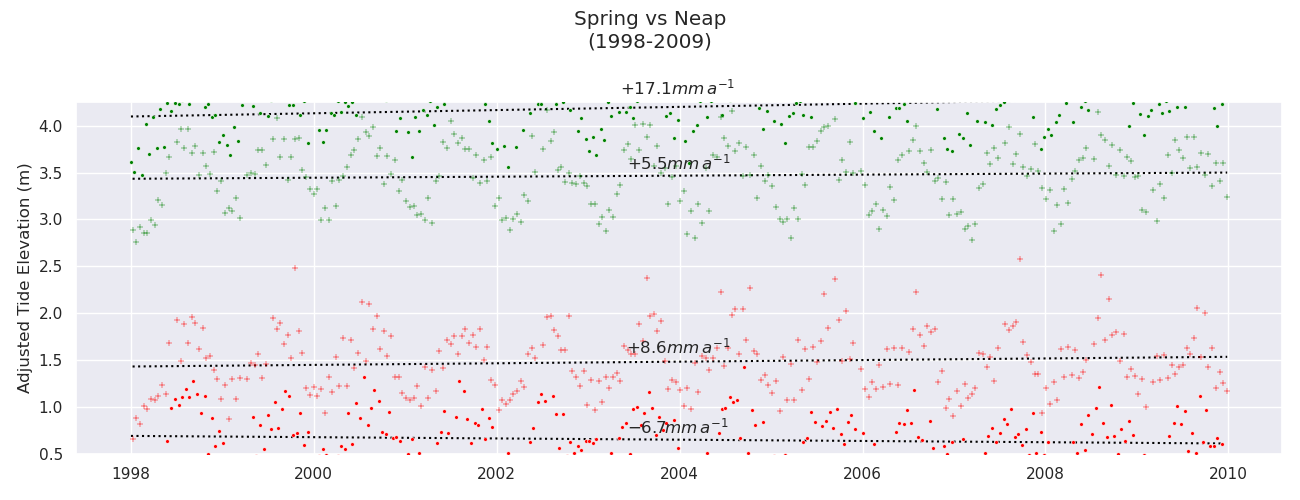

In [162]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=springs.reset_index(), x="datetime", y="HW_adj", color="green", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="HW_adj", color="green", marker="+", s=20, ax=ax, zorder=15)
sns.scatterplot(data=springs.reset_index(), x="datetime", y="LW_adj", color="red", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="LW_adj", color="red", marker="+", s=20, ax=ax, zorder=15)

sns.lineplot(data=spring_lm.HW_adj.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.HW_adj.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=spring_lm.LW_adj.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.LW_adj.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_lm.HW_adj.TS.index.mean(), y=spring_lm.HW_adj.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.HW_adj.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.HW_adj.TS.index.mean(), y=neap_lm.HW_adj.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.HW_adj.coef * 1000), fontsize="medium")
ax.text(x=spring_lm.LW_adj.TS.index.mean(), y=spring_lm.LW_adj.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.LW_adj.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.LW_adj.TS.index.mean(), y=neap_lm.LW_adj.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.LW_adj.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Adjusted Tide Elevation (m)")
ax.set_ylim(0.5, 4.25)

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

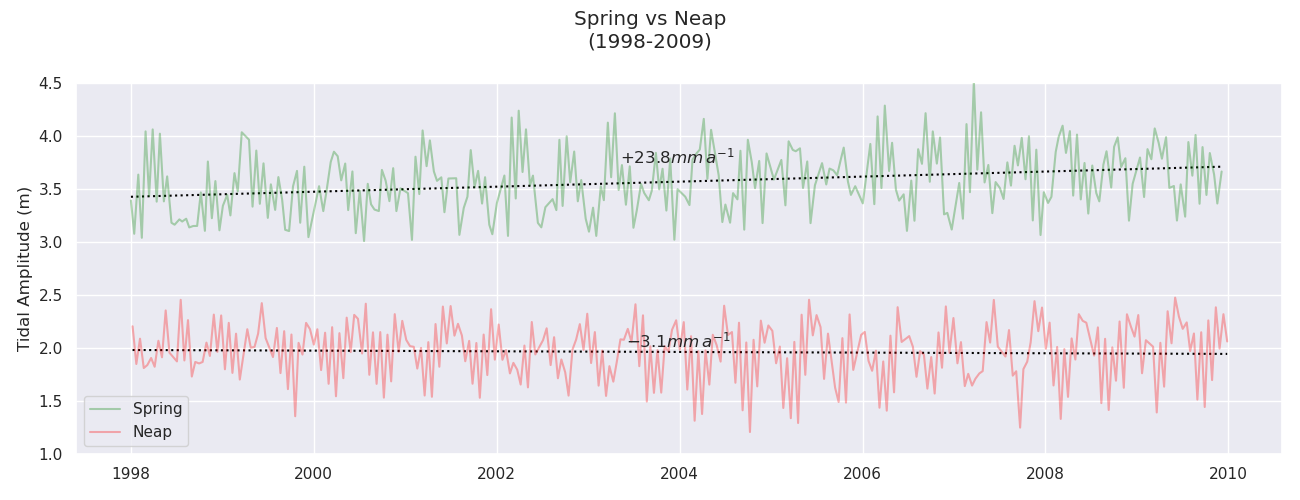

In [19]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

spring_amp = spring_lm.HW_adj.TS - spring_lm.LW_adj.TS
spring_amp_coef = spring_lm.HW_adj.coef - spring_lm.LW_adj.coef
neap_amp = neap_lm.HW_adj.TS - neap_lm.LW_adj.TS
neap_amp_coef = neap_lm.HW_adj.coef - neap_lm.LW_adj.coef

sns.lineplot(x=springs.HW_adj.index, y=springs.HW_adj - springs.LW_adj, color="green", alpha=0.3, ax=ax, zorder=15, label="Spring")
sns.lineplot(x=neaps.HW_adj.index, y=neaps.HW_adj - neaps.LW_adj, color="red", alpha=0.3, ax=ax, zorder=15, label="Neap")

sns.lineplot(data=spring_amp, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_amp, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_amp.index.mean(), y=spring_amp.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_amp_coef * 1000), fontsize="medium")
ax.text(x=neap_amp.index.mean(), y=neap_amp.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_amp_coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Tidal Amplitude (m)")
ax.set_ylim(1, 4.5)

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [ ]:
tides = features.load_tide(wdir, "interim/tides-50yr-30s.feather")
tides = tides.to_frame(name="elevation")

tides["elapsed"] = tides.index - tides.index[0]
tides["nodal"] = nodal_amp * np.sin(2 * np.pi * ((tides.index - phase_start.tz_localize(tz="Asia/Dhaka")) / (pd.Timedelta("365.25 days") * nodal_freq)) + np.pi / 2)

In [ ]:
freq = tides.index.freq
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)

tides[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=tides.elevation.values, distance=distance)[0]
lo = find_peaks(x=tides.elevation.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

tides["high_roll"] = tides.loc[tides.high == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll - tides.elevation.rolling()

In [ ]:
(tides.index - tides.index[0]).total_seconds().astype(int)

In [ ]:
window / pd.Timedelta(freq)

In [ ]:
window = pd.Timedelta("27 hour")
exog = (tides.index - tides.index[0]).total_seconds().astype(int)
frac = window * 3 / pd.Timedelta(freq) / len(tides)
delta = window * 3 / pd.Timedelta(freq)
endogs = (tides.high_roll.values, tides.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

In [ ]:
tides.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + tides.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
tides.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + tides.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
tides["amp_smooth"] = tides.high_smooth - tides.low_smooth

In [ ]:
tides[["spring", "neap"]] = False
distance = n_per_hour * 24 * 10 # search distance in hours
hi = find_peaks(x=tides.amp_roll.values, distance=distance)[0]
lo = find_peaks(x=tides.amp_roll.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "spring"] = True
tides.loc[tides.iloc[lo].index, "neap"] = True

In [ ]:
window = window
start = pd.to_datetime("2020-01-01").tz_localize(tz="Asia/Dhaka")
end = start + pd.Timedelta("30D")

pdata = tides.loc[start:end]
pdata_resample = pdata.resample(rule=pd.Timedelta("30 min", on="datetime")).first().reset_index()
pdata = pdata.reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata_resample, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata_resample, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata_resample, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
# sns.lineplot(data=pdata, x="datetime", y="amp_roll", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali\n{} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [ ]:
# subset highs and lows
highs = tides.loc[tides.high == True][["elapsed", "elevation", "nodal"]]
lows = tides.loc[subset.low == True][["elapsed", "elevation", "nodal"]]

# remove nodal tide
highs["elev_adj"] = highs.elevation - highs.nodal
lows["elev_adj"] = lows.elevation - lows.nodal

# add column of beta adjustments
highs["beta_spring"] = highs.elapsed / pd.Timedelta("1Y") * spring_lm.HW_adj.coef
highs["beta_neap"] = highs.elapsed / pd.Timedelta("1Y") * neap_lm.HW_adj.coef

lows["beta_spring"] = lows.elapsed / pd.Timedelta("1Y") * spring_lm.LW_adj.coef
lows["beta_neap"] = lows.elapsed / pd.Timedelta("1Y") * neap_lm.LW_adj.coef

# merge into one df
nodes = pd.concat([highs, lows], keys=("high", "low"), names=("type", "datetime")).reset_index(level=["type"]).sort_index()

In [ ]:
spring_prox = np.empty(0)
for loc in nodes.index:
    spring_loc = subset.loc[subset.spring == True].iloc[subset.loc[subset.spring == True].index.get_loc(loc, method="nearest")].name
    spring_prox = np.append(arr=spring_prox, values=abs(loc - spring_loc))

In [ ]:
nodes["amp_factor"] = (100 - pd.qcut(x=spring_prox / pd.Timedelta("1D"), q=100, labels=False)) / 100
nodes["elev_amp"] = nodes.elev_adj + (nodes.beta_spring - nodes.beta_neap) * nodes.amp_factor + nodes.beta_neap

In [ ]:
df1 = nodes[["type", "elev_adj", "elev_amp"]].rename(columns={"elev_adj": "old", "elev_amp": "new"})
df1 = df1.append([{"datetime": (df1.datetime.iat[0] - df1.datetime.diff().mean()).round("30S")}][])

In [ ]:
df1.loc["1999-03-25":]

In [ ]:
df1.join(df1.index.to_series().diff()).datetime.sort_values(ascending=False)

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.histplot(data=df1.join(df1.index.to_series().diff()).datetime / pd.Timedelta("1D"))

In [ ]:
df2 = df1.join(other=df1.shift(-1), lsuffix="_1", rsuffix="_2").rename(columns={"datetime_1": "start", "datetime_2": "stop"})

In [ ]:
lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)

In [ ]:
tides = subset
highs = nodes.loc[nodes.type=="high"].reset_index()[["datetime", "elev_amp"]]
highs = highs.append([{"datetime": (highs.datetime.iat[-1] + highs.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
highs["elapsed_yr"] = (highs.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()
lows = nodes.loc[nodes.type=="low"].reset_index()[["datetime", "elev_amp"]]
lows = lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
lows["elapsed_yr"] = (lows.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()

low_subset = lows.iloc[::2].iloc[1:]
low_interp = interp1d(x=low_subset.elapsed_yr, y=low_subset.elev_amp, fill_value="extrapolate", kind="linear")
lows.loc[0, "elev_amp"] = low_interp(lows.elapsed_yr.iat[0])

high_subset = highs.iloc[1::2].iloc[:-1]
high_interp = interp1d(x=high_subset.elapsed_yr, y=high_subset.elev_amp, fill_value="extrapolate", kind="linear")
highs.loc[highs.index[-1], "elev_amp"] = high_interp(highs.elapsed_yr.iat[-1])

df1 = lows.join(other=highs, lsuffix="_low", rsuffix="_high").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df1["type"] = "low-high"

df2 = highs[:-1].join(other=lows.shift(-1)[:-1], lsuffix="_high", rsuffix="_low").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df2["type"] = "high-low"

df1.columns = ["start", "low", "stop", "high", "type"]
df2.columns = ["start", "high", "stop", "low", "type"]


df = pd.concat(objs=[df1, df2]).set_index("start").sort_index().reset_index()

# df = df[["start", "stop", "type", "high_old", "high_new", "low_old", "low_new"]]
# df.index.name = "tide"

In [ ]:
highs

In [ ]:
tides = subset
highs = nodes.loc[nodes.type=="high"].reset_index()[["datetime", "elevation"]]
highs = highs.append([{"datetime": (highs.datetime.iat[-1] + highs.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
highs["elapsed_yr"] = (highs.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()
lows = nodes.loc[nodes.type=="low"].reset_index()[["datetime", "elevation"]]
lows = lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
lows["elapsed_yr"] = (lows.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()

low_subset = lows.iloc[::2].iloc[1:]
low_interp = interp1d(x=low_subset.elapsed_yr, y=low_subset.elevation, fill_value="extrapolate", kind="linear")
lows.loc[0, "elevation"] = low_interp(lows.elapsed_yr.iat[0])

high_subset = highs.iloc[1::2].iloc[:-1]
high_interp = interp1d(x=high_subset.elapsed_yr, y=high_subset.elevation, fill_value="extrapolate", kind="linear")
highs.loc[highs.index[-1], "elevation"] = high_interp(highs.elapsed_yr.iat[-1])

highs["elevation_new"] = highs.elevation + highs.elapsed_yr * beta_mean_high
lows["elevation_new"] = lows.elevation + lows.elapsed_yr * beta_mean_low

df1 = lows.join(other=highs, lsuffix="_low", rsuffix="_high").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df1["type"] = "low-high"

df2 = highs[:-1].join(other=lows.shift(-1)[:-1], lsuffix="_high", rsuffix="_low").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df2["type"] = "high-low"

df1.columns = ["start", "low_old", "low_new", "stop", "high_old", "high_new", "type"]
df2.columns = ["start", "high_old", "high_new", "stop", "low_old", "low_new", "type"]


df = pd.concat(objs=[df1, df2]).set_index("start").sort_index().reset_index()

df = df[["start", "stop", "type", "high_old", "high_new", "low_old", "low_new"]]
df.index.name = "tide"

In [ ]:
def stretch_limb(limb, old_range: list(), new_range: list()):
    tide = limb.copy()
    tide["elevation"] = new_range[0] + ((tide.elevation - old_range[0]) * (new_range[1] - new_range[0])) / (tide.elevation.max() - old_range[0])
    return tide

In [ ]:
new = Parallel(n_jobs=-1)(delayed(stretch_limb)(
    limb=tides.loc[row.start:row.stop],
    old_range=[row.low_old, row.high_old],
    new_range=[row.low_new, row.high_new]
    ) for row in df.itertuples())
tides_new = pd.concat(new).reset_index().drop_duplicates(subset=["datetime"]).set_index("datetime").sort_index()

In [ ]:
nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal
df = s.groupby(pd.Grouper(freq="AS")).apply(lambda x: x.quantile(q=np.arange(0,1.1,0.1))).unstack(0)
df.columns = df.columns.year
df.columns.name = "year"
df.index.name = "quantile"

In [ ]:
s = data.loc["1998":].elevation.copy()

nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal
quants = np.arange(0, 1.01, 0.01)
df = s.groupby(pd.Grouper(freq="AS")).apply(lambda x: x.quantile(q=quants)).unstack(0)

df.index = df.index.values.round(2)
df.columns = df.columns.year
df.columns.name = "year"
df.index.name = "quantile"

fig = plt.figure(figsize=(15, 5))
ax = fig.subplots()

sns.heatmap(df.T.sort_index(ascending=False), xticklabels=10, cmap="mako", ax=ax)

In [ ]:
s = data.loc["1998":].elevation.copy()

nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal

sd = s.groupby(by=pd.Grouper(freq="D")).mean().interpolate(method="time", limit_direction="both")
res = STL(endog=sd, trend=365).fit()
seasonal = res.trend.reindex(index=s.index).interpolate(method="time", limit_direction="both")

s = s - seasonal

df = s.to_frame(name="elevation")
df["year"] = df.index.year
df["timedelta"] = df.index - pd.to_datetime(df.index.year, format="%Y")
df = df.groupby(["year", "timedelta"]).mean().unstack(0)
df.index = (df.index / pd.Timedelta(days=1)).values.round(2)
df.columns = df.columns.droplevel(0)

fig = plt.figure(figsize=(18, 5))
ax = fig.subplots()

pdata = df

sns.heatmap(pdata.T.sort_index(ascending=False), xticklabels=df.index.size//6, cmap="mako", robust=True, ax=ax)
plt.tight_layout()